# Finding new clusters for better classifying

Ticket link: https://github.com/kowaalczyk/astronomical-classification/projects/1#card-15537673a

In [1]:
import gc
import pandas as pd
import numpy as np
import dask.dataframe as dd

from datetime import datetime as dt
from functools import partial, wraps

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from numba import jit
import matplotlib.pyplot as plt
from experiments import start_run, log_args
import plasticc.xgb_train as xgb
import plasticc.lgbm_train as lgbm
from plasticc.training import process_meta
from plasticc.featurize import featurize
from plasticc.lgbm_train import lgbm_modeling_cross_validation
from plasticc.xgb_train import xgb_modeling_cross_validation

In [2]:
gc.enable()

In [3]:
training_df = dd.read_csv("../../../kk385830/astronomical-classification/data/raw/training_set.csv")
training_meta_df = dd.read_csv("../../../kk385830/astronomical-classification/data/raw/training_set_metadata.csv")
test_df = dd.read_csv("../../../kk385830/astronomical-classification/data/raw/test_set.csv")
test_meta_df = dd.read_csv("../../../kk385830/astronomical-classification/data/raw/test_set_metadata.csv")

## Data featurization
We will now featurize the training data and using CV we will check how does it perform

In [4]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [5]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

In [6]:
%%time
meta_train = process_meta("../../../kk385830/astronomical-classification/data/raw/training_set_metadata.csv")
train = pd.read_csv("../../../kk385830/astronomical-classification/data/raw/training_set.csv")

CPU times: user 1.45 s, sys: 68 ms, total: 1.52 s
Wall time: 1.51 s


In [7]:
%%time
X = featurize(train, meta_train, aggs, fcp)
X_backup = X.copy()

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 24.37it/s]


CPU times: user 23.6 s, sys: 1.74 s, total: 25.4 s
Wall time: 30 s


## Setting up CV

In [14]:
# lgbm_params = {
#     'device': 'cpu',
#     'objective': 'multiclass',
#     'num_class': 14,
#     'boosting_type': 'gbdt',
#     'n_jobs': 16,
#     'max_depth': 7,
#     'n_estimators': 1024,
#     'subsample_freq': 2,
#     'subsample_for_bin': 5000,
#     'min_data_per_group': 100,
#     'max_cat_to_onehot': 4,
#     'cat_l2': 1.0,
#     'cat_smooth': 59.5,
#     'max_cat_threshold': 32,
#     'metric_freq': 10,
#     'verbosity': -1,
#     'metric': 'multi_logloss',
#     'xgboost_dart_mode': False,
#     'uniform_drop': False,
#     'colsample_bytree': 0.5,
#     'drop_rate': 0.173,
#     'learning_rate': 0.0267,
#     'max_drop': 5,
#     'min_child_samples': 10,
#     'min_child_weight': 100.0,
#     'min_split_gain': 0.1,
#     'num_leaves': 7,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.00023,
#     'skip_drop': 0.44,
#     'subsample': 0.75
# }
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 7,
    'n_estimators': 1024,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.0267,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.1,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 127
}

In [9]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the heck")

In [10]:
# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
classes = sorted(y.unique())
class_weights = {c: 1 for c in classes}
class_weights.update({c:2 for c in [64, 15]})
print('Unique classes : {}, {}'.format(len(classes), classes))
print(class_weights)

Unique classes : 14, [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
{6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}


In [11]:
def test_partition(mask, lgbm_conf1, lgbm_conf2):
    """ mask is a lambda operating on training set, returning boolean values to split the set"""
    result_mine = []
    X_after1 = X_backup[mask]
    X_after2 = X_backup[~mask]
    y1 = 0
    y2 = 0
    for t in [[X_after1, y1, lgbm_conf1], [X_after2, y2, lgbm_conf2]]:
        if 'object_id' in t[0]:
            t[1] = pd.Series(t[0]['target'])
            del t[0]['target']
            del t[0]['object_id'] 
            del t[0]['hostgal_specz']
            del t[0]['ra'], t[0]['decl'], t[0]['gal_l'], t[0]['gal_b']
            del t[0]['ddf']
        else:
            print(f"What the heck: {t}")
        eval_func = partial(
            lgbm_modeling_cross_validation, 
            X=t[0], 
            y=t[1], 
            classes=classes, 
            class_weights=class_weights, 
            nr_fold=5, 
            random_state=1
        )
        clfs, score = eval_func(t[2])
        result_mine.append(score)
    print(result_mine)

### Baseline
Before starting, let's take a look at how lgbm perform on full training set

In [75]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': -1,
    'max_depth': 6,
    'n_estimators': 1024,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.0267,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.125,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 127,
    'min_data_in_leaf': 15,
    'lambda_l1': 2,
}
baseline_X = X_backup.copy()
if 'object_id' in baseline_X:
    baseline_Y = pd.Series(baseline_X['target'])
    del baseline_X['target']
    del baseline_X['object_id'] 
    del baseline_X['hostgal_specz']
    del baseline_X['ra'], baseline_X['decl'], baseline_X['gal_l'], baseline_X['gal_b']
    del baseline_X['ddf']
else:
    print("What the heck")
eval_func = partial(
    lgbm_modeling_cross_validation, 
    X=baseline_X, 
    y=baseline_Y, 
    classes=classes, 
    class_weights=class_weights, 
    nr_fold=5, 
    random_state=1
)
clfs, score = eval_func(lgbm_params)
print(score)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.750935	training's wloss: 0.741731	valid_1's multi_logloss: 1.10099	valid_1's wloss: 0.922687
[200]	training's multi_logloss: 0.494877	training's wloss: 0.484055	valid_1's multi_logloss: 0.877025	valid_1's wloss: 0.718502
[300]	training's multi_logloss: 0.392809	training's wloss: 0.380971	valid_1's multi_logloss: 0.799104	valid_1's wloss: 0.662541
[400]	training's multi_logloss: 0.333664	training's wloss: 0.321899	valid_1's multi_logloss: 0.757612	valid_1's wloss: 0.644261
[500]	training's multi_logloss: 0.291283	training's wloss: 0.27965	valid_1's multi_logloss: 0.730563	valid_1's wloss: 0.638828
[600]	training's multi_logloss: 0.257753	training's wloss: 0.246717	valid_1's multi_logloss: 0.709965	valid_1's wloss: 0.63717
Early stopping, best iteration is:
[612]	training's multi_logloss: 0.254154	training's wloss: 0.243198	valid_1's multi_logloss: 0.707486	valid_1's wloss: 0.636651
no 1-fold 

Score: 0.6501199352977585  
0.6463362734878486 'max_bin': 95,  
0.6461180983317429 'max_bin': 127,  
0.6450608843517845 'max_bin': 127, 'min_data_in_leaf': 15  
0.6445799942947439 'max_bin': 127, 'min_data_in_leaf': 15, 'lambda_l1': 2,  
0.6442824787482899 'max_bin': 127, 'min_data_in_leaf': 15, 'lambda_l1': 2, 'min_split_gain': 0.125,


### First Idea:
Let's split data by first feature from metadata - ra(right ascension, sky coordinate: co-longitude in degrees).  
We split somewhere between 250 and 300 -  it looks quite promising as both of the sets have similar distribution

(array([101., 111.,  53.,  15.,  20.,  15.,  13.,  12.,  13.,  14.,  19.,
         18.,  12.,  17.,  17.,  17.,  12.,  18.,  16.,  13.,   9.,  14.,
         17.,  11.,  10.,  15.,  17.,  20.,  15.,  23.,  18.,  16.,  57.,
        149., 106.,  45.,  12.,  23.,  16.,  18.,  17.,  14.,  13.,  17.,
         18.,   8.,  19.,  13.,  12.,  16.,  18., 119., 153., 201.,  33.,
         21.,  22.,  23.,  18.,  23.,  27.,  11.,  24.,  16.,  19.,  15.,
         25.,  24.,  19.,  22.,  16.,  23.,  14.,  23.,  24.,  25.,  17.,
         19.,  25.,  17.,  18.,  16.,  20.,  16.,  16.,  25.,  20.,  26.,
         20.,  14.,  18.,  18.,  12.,  16.,  13.,  13.,  16.,  26.,  17.,
         15.,  12.,  13.,  22.,  19.,  16.,  18.,  18.,  17.,  18.,  22.,
         24.,  17.,  22.,  13.,  25.,  16.,  17.,  14.,  22.,  27.,  25.,
         20.,  19.,  16.,  29.,  15.,  26.,  21.,  11.,  26.,  17.,   7.,
         29.,  18.,  16.,  17.,  26.,  16.,  15.,  11.,  20.,  20.,  19.,
         20.,  19.,  28.,  18.,  14., 

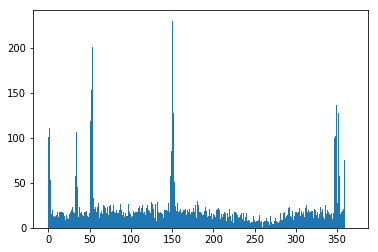

In [12]:
plt.hist(training_meta_df.ra.compute(),  bins=range(0, 370))

(array([13080., 14045., 11932., 11295., 11423., 11824.,  9964., 11667.,
        12070., 10603., 12278., 11207., 10147., 11832., 12336., 11238.,
        10646., 12078., 13442., 10757., 13275., 11496., 10139., 11408.,
        13195., 11258., 12056., 11914., 11524., 11958., 11984., 11141.,
        11332., 14023., 12562., 10468., 11598., 13013., 11237., 12478.,
        13216., 11361., 11942., 11951., 10818., 13098., 11842., 13116.,
        11507., 11027., 11931., 11444., 12816., 17367., 12083., 13271.,
        12021., 10056., 13484., 12711., 11810.,  9951., 12295., 12741.,
        11325., 12207., 12924., 12280., 13438., 13548., 11252., 12420.,
        12421., 13269., 13443., 12856., 13043., 10810., 12453., 12745.,
        11057., 12250., 11941.,  9330., 12612., 11175.,  9786., 11448.,
         9978.,  8089.,  9536., 10869.,  9765.,  9619., 10743.,  9862.,
         8438., 11023., 10867.,  9248.,  8444.,  9496.,  8467.,  8452.,
         8287.,  9502.,  8830., 10067., 10161.,  8554., 10311., 

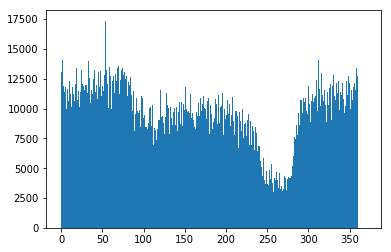

In [13]:
plt.hist(test_meta_df.ra.compute(), bins=range(0, 370))

With scores around 0.7031538683880986, 0.8434040355315483 for the first and second subset, I find it pointless to continue exploration

In [12]:
#[0.7031538683880986, 0.8434040355315483] default
conf1 = lgbm_params.copy()
conf2 = lgbm_params.copy()
test_partition(X_backup.ra < 300, conf1, conf2)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.730788	training's wloss: 0.72294	valid_1's multi_logloss: 1.08259	valid_1's wloss: 0.955054
[200]	training's multi_logloss: 0.466244	training's wloss: 0.457483	valid_1's multi_logloss: 0.854245	valid_1's wloss: 0.751777
[300]	training's multi_logloss: 0.362049	training's wloss: 0.352558	valid_1's multi_logloss: 0.775381	valid_1's wloss: 0.699794
[400]	training's multi_logloss: 0.301631	training's wloss: 0.29218	valid_1's multi_logloss: 0.734183	valid_1's wloss: 0.687222
[500]	training's multi_logloss: 0.258039	training's wloss: 0.248995	valid_1's multi_logloss: 0.708062	valid_1's wloss: 0.682924
Early stopping, best iteration is:
[494]	training's multi_logloss: 0.260378	training's wloss: 0.251343	valid_1's multi_logloss: 0.708906	valid_1's wloss: 0.682258
no 1-fold loss: 0.6822575664421102
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.726765	

### Second Idea:
Now it's time for gal_l, but spliting into to sets where one of them a few times smaller than the second one wouldn't make sense.  
[1.023404000997548, 0.6577501966844485]

(array([454924., 215179.,  77648.,  52456.,  98288., 274602., 696963.,
        629739., 420570., 572521.]),
 array([1.03690000e-02, 3.60088876e+01, 7.20074062e+01, 1.08005925e+02,
        1.44004443e+02, 1.80002962e+02, 2.16001481e+02, 2.51999999e+02,
        2.87998518e+02, 3.23997036e+02, 3.59995555e+02]),
 <a list of 10 Patch objects>)

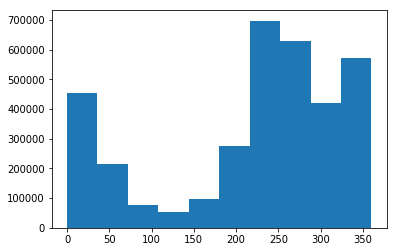

In [77]:
plt.hist(test_meta_df.gal_l.compute())

(array([ 725.,  355.,  105.,   85.,  437.,  409., 2102., 1179., 1229.,
        1222.]),
 array([1.07681000e-01, 3.60912956e+01, 7.20749102e+01, 1.08058525e+02,
        1.44042139e+02, 1.80025754e+02, 2.16009369e+02, 2.51992983e+02,
        2.87976598e+02, 3.23960212e+02, 3.59943827e+02]),
 <a list of 10 Patch objects>)

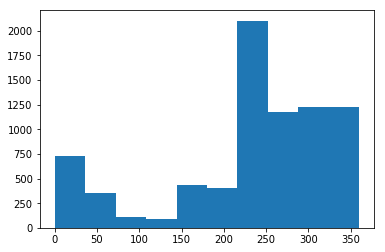

In [78]:
plt.hist(training_meta_df.gal_l.compute())

In [79]:
#[0.7031538683880986, 0.8434040355315483] default
conf1 = lgbm_params.copy()
conf2 = lgbm_params.copy()
test_partition(X_backup.gal_l < 125, conf1, conf2)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.63278	training's wloss: 0.628306	valid_1's multi_logloss: 1.21719	valid_1's wloss: 1.28554
[200]	training's multi_logloss: 0.319308	training's wloss: 0.31686	valid_1's multi_logloss: 0.989025	valid_1's wloss: 1.13724
[300]	training's multi_logloss: 0.230568	training's wloss: 0.228667	valid_1's multi_logloss: 0.948943	valid_1's wloss: 1.11927
Early stopping, best iteration is:
[278]	training's multi_logloss: 0.243896	training's wloss: 0.241801	valid_1's multi_logloss: 0.952442	valid_1's wloss: 1.11491
no 1-fold loss: 1.1149067859705455
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.634914	training's wloss: 0.636037	valid_1's multi_logloss: 1.12698	valid_1's wloss: 1.16548
[200]	training's multi_logloss: 0.321901	training's wloss: 0.321937	valid_1's multi_logloss: 0.9079	valid_1's wloss: 1.03795
[300]	training's multi_logloss: 0.232639	training'

### Third Idea:
I think look at test data histogram shows firmly, that this wouldn't make sense

(array([5732.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2116.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

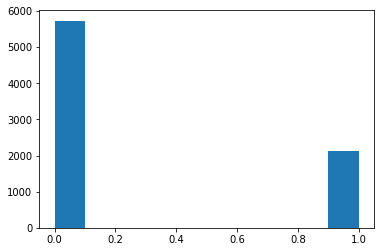

In [54]:
plt.hist(training_meta_df.ddf.compute())

(array([3459964.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,   32926.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

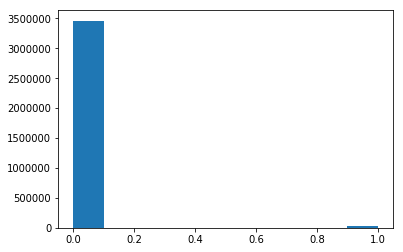

In [55]:
plt.hist(test_meta_df.ddf.compute())

### Fourth Idea:  
No space for splitting set, I guess

7848
2325


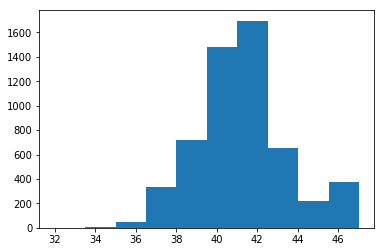

In [71]:
plt.hist(training_meta_df.distmod.compute())
print(training_meta_df.shape[0].compute())
print(training_meta_df.distmod.isna().sum().compute())

/home/mf385423/miniconda3/envs/plasticc/lib/python3.6/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mf385423/miniconda3/envs/plasticc/lib/python3.6/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


3492890
390510


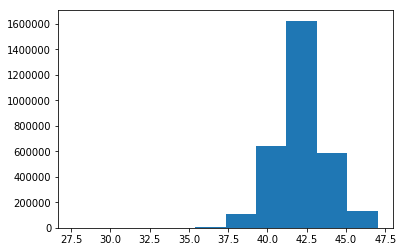

In [70]:
plt.hist(test_meta_df.distmod.compute())
print(test_meta_df.shape[0].compute())
print(test_meta_df.distmod.isna().sum().compute())

### Fifth Idea:  
Unfortunately pointless (I was hoping for it)

(array([4816., 1487.,  557.,  169.,  132.,  105.,   92.,  101.,  139.,
         250.]),
 array([0.00568182, 0.10511364, 0.20454545, 0.30397727, 0.40340909,
        0.50284091, 0.60227273, 0.70170455, 0.80113636, 0.90056818,
        1.        ]),
 <a list of 10 Patch objects>)

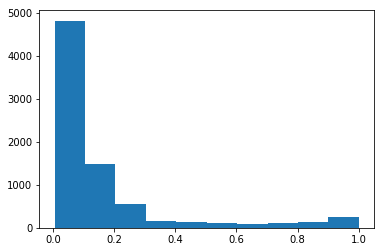

In [95]:
plt.hist(training_df.groupby(['object_id']).mean().compute().detected)

### Sixth Idea:  
Also pointless

(array([0.000e+00, 0.000e+00, 1.666e+03, 2.780e+02, 5.000e+01, 1.600e+01,
        3.900e+01, 9.000e+00, 8.000e+00, 3.600e+01, 1.900e+02, 7.440e+02,
        1.030e+03, 8.410e+02, 6.950e+02, 4.750e+02, 2.680e+02, 1.730e+02,
        1.390e+02, 1.170e+02, 1.060e+02, 1.010e+02, 8.900e+01, 7.500e+01,
        6.700e+01, 4.700e+01, 2.800e+01, 2.800e+01, 3.100e+01, 2.200e+01,
        2.000e+01, 1.900e+01, 1.600e+01, 1.900e+01, 1.100e+01, 1.700e+01,
        1.600e+01, 1.700e+01, 1.400e+01, 1.400e+01, 5.000e+00, 5.000e+00,
        1.200e+01, 1.000e+01, 1.000e+01, 9.000e+00, 8.000e+00, 4.000e+00,
        5.000e+00, 5.000e+00, 1.000e+01, 4.000e+00, 1.100e+01, 5.000e+00,
        2.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 4.000e+00, 4.000e+00,
        4.000e+00, 5.000e+00, 4.000e+00, 8.000e+00, 2.000e+00, 5.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 7.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

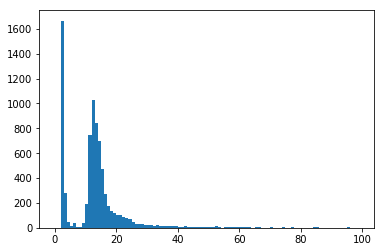

In [100]:
plt.hist(training_df.groupby(['object_id']).mean().compute().flux_err, bins=range(0, 100))

(array([0.00000e+00, 0.00000e+00, 3.25110e+04, 2.76000e+02, 9.00000e+00,
        7.00000e+00, 6.00000e+00, 5.00000e+00, 1.53800e+03, 2.39210e+04,
        1.64828e+05, 6.37368e+05, 7.79833e+05, 5.45294e+05, 4.18394e+05,
        2.37091e+05, 1.14608e+05, 6.76270e+04, 5.05820e+04, 3.66470e+04,
        3.01750e+04, 2.58860e+04, 2.23180e+04, 1.92560e+04, 1.68360e+04,
        1.35270e+04, 1.17730e+04, 1.04720e+04, 9.69700e+03, 8.69800e+03,
        7.81100e+03, 7.62800e+03, 7.40500e+03, 6.62700e+03, 6.65000e+03,
        6.36400e+03, 6.41400e+03, 6.12400e+03, 5.85200e+03, 5.38100e+03,
        4.91800e+03, 4.30700e+03, 4.22300e+03, 3.84600e+03, 3.67000e+03,
        3.46800e+03, 3.37000e+03, 2.95800e+03, 2.86500e+03, 2.78900e+03,
        2.67700e+03, 2.56200e+03, 2.36600e+03, 2.22100e+03, 2.17400e+03,
        1.98300e+03, 2.03100e+03, 1.89400e+03, 1.80200e+03, 1.69200e+03,
        1.65700e+03, 1.55000e+03, 1.48600e+03, 1.51100e+03, 1.29000e+03,
        1.33900e+03, 1.32100e+03, 1.27700e+03, 1.20

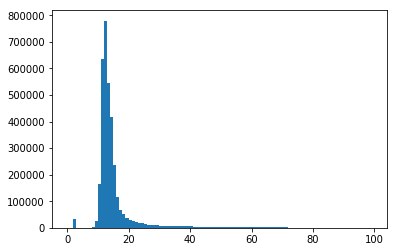

In [101]:
plt.hist(test_df.groupby(['object_id']).mean().compute().flux_err, bins=range(0, 100))

### Seventh Idea:  
Also pointless

(array([7.300e+01, 4.290e+02, 3.738e+03, 1.492e+03, 0.000e+00, 0.000e+00,
        4.700e+02, 0.000e+00, 2.000e+00, 1.644e+03]),
 array([ 47. ,  77.5, 108. , 138.5, 169. , 199.5, 230. , 260.5, 291. ,
        321.5, 352. ]),
 <a list of 10 Patch objects>)

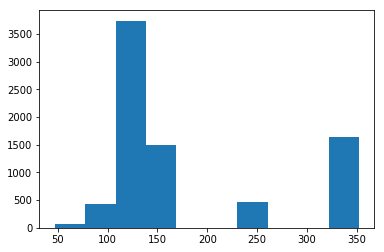

In [102]:
plt.hist(training_df.groupby(['object_id']).count().compute().flux)

(array([2.808700e+04, 2.000660e+05, 2.173524e+06, 1.057672e+06,
        6.150000e+02, 0.000000e+00, 6.215000e+03, 0.000000e+00,
        0.000000e+00, 2.671100e+04]),
 array([ 45. ,  75.7, 106.4, 137.1, 167.8, 198.5, 229.2, 259.9, 290.6,
        321.3, 352. ]),
 <a list of 10 Patch objects>)

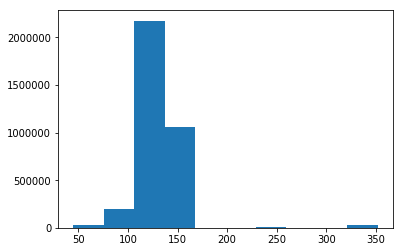

In [103]:
plt.hist(test_df.groupby(['object_id']).count().compute().flux)